In [54]:
from tqdm import tqdm
import pickle
import random
import numpy as np

from copy import deepcopy

from time import sleep
from collections import defaultdict
from grid import Grid, RandomGridGenerator

from IPython.display import clear_output
from utils import two_int_to_hash, numpy_arr_to_str, approximate_5x5_to_3x3

import matplotlib.pyplot as plt

In [55]:
# GLOBAL CONFIGS
GRID_NUMBER_OF_ROWS = 50
GRID_NUMBER_OF_COLS = 50

PREDATOR_VISION_DIST = 3
PREY_VISION_DIST = 2

PREDATOR_VALUE = 2
PREY_VALUE = 1

PREDATOR_APPROXIMATE_SHARE = 0.2
PREY_APPROXIMATE_SHARE = 0.8

PREDATOR_DEFAULT_HEALTH = 50
PREY_DEFAULT_HEALTH = 10000

PREY_OFFSPRING_RATE = 7
PREDATOR_OFFSPRING_RATE = 100

LIFE_EXTENDER_WHEN_EATING = 10

alpha = 0.1
gamma = 0.6
epsilon = 0.1

action_space = [
    "up",
    "down",
    "left",
    "right",
    "stay",
]


action_idxs = [0,1,2,3,4]


with open("DL_pretrained_model/predator_q_table.pickle", "rb") as f:
    pre_trained_data_predator = pickle.load(f)

    
with open("DL_pretrained_model/prey_q_table.pickle", "rb") as f:
    pre_trained_data_prey = pickle.load(f)


In [56]:
class AgentNet:
    def __init__(self, _type):
        self.q_table = dict()
        self._type = _type

    def choose_next_cell(self, state, _next):
        if state.shape[0] == 5:
            state = approximate_5x5_to_3x3(state)

        hashed_state = numpy_arr_to_str(state)

        if hashed_state not in self.q_table:
             self.q_table[hashed_state] = self._get_default_knowledge(hashed_state)

        allowed_actions = self._get_allowed_actions(_next)
        if random.uniform(0, 1) < epsilon:
            try:
                return random.choice(allowed_actions)
            except:
                return 4
        else:
            try:
                max_indices = np.where(self.q_table[hashed_state] == np.max(self.q_table[hashed_state][allowed_actions]))[0]
                return random.choice(max_indices)
            except:
                return 4

    def _get_allowed_actions(self, _next):
        actions = []
        if self._type == "prey":
            allowed_options = (0,)
        else:
            allowed_options = (0,1)
            
        if _next[1][1] in allowed_options:
            actions.append(4)

        if _next[0][1] in allowed_options:
            actions.append(0)

        if _next[2][1] in allowed_options:
            actions.append(1)

        if _next[1][0] in allowed_options:
            actions.append(2)

        if _next[1][2] in allowed_options:
            actions.append(3)

            
        # if len(actions) == 0:
        #     print(f"No action available, a {_type} died")

        return actions

    def _get_default_knowledge(self, hashed_state):
        if self._type == "predator":
            val = pre_trained_data_predator[hashed_state]
        elif self._type == "prey":
            val = pre_trained_data_prey[hashed_state]

        else:
            raise Exception(f"Invalid type {_type}")
        return np.array(
            [
            val[1],
            val[3],
            val[4],
            val[2],
            val[0],])

In [57]:
predator_net = AgentNet("predator")
prey_net = AgentNet("prey")

In [58]:
class Animal:
    __slots__ = "last_move", "remaining_life", "time_left_to_offspring", "trajectory", "_type"
    def __init__(self, remaining_life, _type):
        self.last_move = None
        self.remaining_life = remaining_life
        if _type == 1:
            self.time_left_to_offspring = PREY_OFFSPRING_RATE
        else:
            self.time_left_to_offspring = PREDATOR_OFFSPRING_RATE
        self._type = _type
        self.trajectory = []

    def process_epoch(self):
        self.remaining_life -= 1
        self.time_left_to_offspring -= 1

    def move(self, vision_matrix, _next):
        if self._type == PREDATOR_VALUE:
            return predator_net.choose_next_cell(vision_matrix, _next)
        elif self._type == PREY_VALUE:
            return prey_net.choose_next_cell(vision_matrix, _next)

In [59]:
def get_dest_from_action(action, row, col):
    action = action_space[action]
    if action == "down":
        return (row+1) % GRID_NUMBER_OF_ROWS, col

    elif action == "up":
        return (row-1) % GRID_NUMBER_OF_ROWS, col

    elif action == "left":
        return row, (col-1)%GRID_NUMBER_OF_COLS

    elif action == "right":
        return row, (col+1)%GRID_NUMBER_OF_COLS

    elif action == "stay":
        return row, col

    else:
        raise Exception(f"Action can't be {action}")
    
def grid_of_nums_to_objects(grid: Grid) -> np.array:
    new_grid = np.empty(grid.grid.shape, dtype=object)
    for rowidx, row in enumerate(grid.grid):
        for colidx, val in enumerate(row):
            if val == PREDATOR_VALUE:     
                new_grid[rowidx][colidx] = Animal(PREDATOR_DEFAULT_HEALTH, PREDATOR_VALUE)
            elif val == PREY_VALUE:
                new_grid[rowidx][colidx] = Animal(PREY_DEFAULT_HEALTH, PREY_VALUE)

    return new_grid


# Main

In [60]:
rgg = RandomGridGenerator(GRID_NUMBER_OF_ROWS, GRID_NUMBER_OF_COLS)
generated_grid = rgg.getGrid(round(PREDATOR_APPROXIMATE_SHARE * 100) * [PREDATOR_VALUE] + round(PREY_APPROXIMATE_SHARE * 100) * [PREY_VALUE], density_threshold=0.95)

In [61]:
def get_offspring_possible_locations(parent_coord, next_grid, search_range):
    if search_range[0] >= GRID_NUMBER_OF_ROWS or search_range[0] >= GRID_NUMBER_OF_COLS:
        print("No offspring")
        return []

    row, col = parent_coord

    possible_locations = []
    for i in search_range:
        for j in search_range:
            if i == 0 and j == 0:
                continue

            new_row = (row + i) % GRID_NUMBER_OF_ROWS
            new_col = (col + j) % GRID_NUMBER_OF_COLS

            if next_grid[new_row, new_col] == 0:
                possible_locations.append([new_row, new_col])
     
    # if len(possible_locations) == 0:
    #     new_search_range = search_range
    #     new_search_range[0] -= 1
    #     new_search_range[2] += 1
    #     return get_offspring_possible_locations(parent_coord, next_grid, new_search_range)

    return possible_locations

In [62]:
grid = Grid(generated_grid)  # Grid object containing the generated grid
object_grid = grid_of_nums_to_objects(grid)   # Same grid but instead of numbers objects are used

In [63]:
history = []


grid = Grid(generated_grid)  # Grid object containing the generated grid
object_grid = grid_of_nums_to_objects(grid)   # Same grid but instead of numbers objects are used
prey_c = []
pred_c = []

rewards = []  # List for keeping the rewards for each timestamp

for time in tqdm(range(200)):
    added = []

    # Variables for keeping the cumulative rewards in the current timestamp
    cumulative_reward_predator = 0  
    cumulative_reward_prey = 0  

    # Empty grids for keeping future states
    next_grid = np.zeros((grid.rown, grid.coln), dtype=np.int64)
    next_object_grid = np.empty(object_grid.shape, dtype=object)

    # Iteration over each item of the grid to move preys
    for row, line in enumerate(grid.grid):
        for col, item in enumerate(line):
            if [row, col] in added:
                continue

            if item == PREY_VALUE:
                prey: Animal = object_grid[row][col]
                prey.process_epoch()  # Decrease remaining life by 1

                # If no life left the prey is removed from both grids
                if prey.remaining_life == 0:
                    grid.grid[row][col] = 0
                    object_grid[row][col] = None
                    continue


                ### OFFSPRING
                if prey.time_left_to_offspring == 0:
                    prey.time_left_to_offspring = PREY_OFFSPRING_RATE

                    for _ in range(2):
                        possible_locations = get_offspring_possible_locations([row, col], next_grid, [-1, 0, 1])

                        if len(possible_locations) >= 1:
                            new_row, new_col = random.choice(possible_locations)
                            next_grid[new_row, new_col] = 1

                            new_prey = Animal(PREY_DEFAULT_HEALTH, PREY_VALUE)
                            new_prey.remaining_life = PREY_DEFAULT_HEALTH
                            next_object_grid[new_row, new_col] = new_prey
                            
                            added.append([new_row, new_col])
                ### END OFFSPRING
                        

                # Prey will always stop at every 4-th step
                if time % 4 != 0:
                    vision_space = grid.getNeighbors(row, col, PREY_VISION_DIST)

                    action = prey.move(vision_space, grid.getNeighborsFromNext(next_grid, row, col, PREY_VISION_DIST))

                    dest = get_dest_from_action(action, row, col)
                    next_grid[dest[0], dest[1]] = item
                    next_object_grid[dest[0], dest[1]] = prey

                    prey.trajectory.append([dest[0], dest[1]])

                    prey.last_move =  (numpy_arr_to_str(vision_space), action)

                else:
                    next_grid[row, col] = item
                    next_object_grid[row, col] = prey
                    prey.trajectory.append([row, col])


    # Iteration over each item of the grid to move predators
    for row, line in enumerate(grid.grid):
        for col, item in enumerate(line):
            if item == PREDATOR_VALUE:

                predator: Animal = object_grid[row][col]
                predator.process_epoch() # Decrease remaining life by 1

                # If no life left the predator is removed from both grids
                if predator.remaining_life == 0:
                    grid.grid[row][col] = 0
                    object_grid[row][col] = None
                    continue

                # ### OFFSPRING
                # if predator.time_left_to_offspring == 0:
                #     predator.time_left_to_offspring = PREDATOR_OFFSPRING_RATE

                #     possible_locations = get_offspring_possible_locations([row, col], next_grid, [-1, 0, 1])

                #     if len(possible_locations) >= 1:
                #         new_row, new_col = random.choice(possible_locations)
                #         next_grid[new_row, new_col] = 2

                #         new_predator = Animal(PREDATOR_DEFAULT_HEALTH, PREDATOR_VALUE)
                #         new_predator.remaining_life = PREDATOR_DEFAULT_HEALTH
                #         next_object_grid[new_row, new_col] = new_predator
                        
                #         added.append([new_row, new_col])
                # ### END OFFSPRING


                reward = 0
                vision_space = grid.getNeighbors(row, col, PREDATOR_VISION_DIST)
                action = predator.move(vision_space, grid.getNeighborsFromNext(next_grid, row, col, PREY_VISION_DIST))

                # Reward for eating a prey
                dest = get_dest_from_action(action, row, col)
                if next_grid[dest[0], dest[1]] == PREY_VALUE:
                    reward = 1
                    predator.remaining_life += LIFE_EXTENDER_WHEN_EATING
                    prey_last_move = next_object_grid[dest[0], dest[1]].last_move
                    if prey_last_move:
                        prey_reward = -1
                        old_q_value = prey_net.q_table[prey_last_move[0]][prey_last_move[1]]
                        new_q_value = (1 - alpha) * old_q_value + alpha * (prey_reward + gamma)
                        prey_net.q_table[prey_last_move[0]][prey_last_move[1]] = new_q_value

                cumulative_reward_predator += reward

                app_next_vs = approximate_5x5_to_3x3(grid.getNeighborsFromNext(next_grid, dest[0], dest[1], PREDATOR_VISION_DIST))
                app_vs = approximate_5x5_to_3x3(vision_space)

                if predator_net.q_table.get(numpy_arr_to_str(app_next_vs)) is None:
                    predator_net.q_table[numpy_arr_to_str(app_next_vs)] = predator_net._get_default_knowledge(numpy_arr_to_str(app_next_vs))

                max_value = np.max(predator_net.q_table[numpy_arr_to_str(app_next_vs)])
                new_q_value = (1 - alpha) * predator_net.q_table[numpy_arr_to_str(app_vs)][action] + alpha * (reward + gamma * max_value)

                predator_net.q_table[numpy_arr_to_str(app_vs)][action] = new_q_value

                predator.trajectory.append([dest[0], dest[1]])

                next_grid[dest[0], dest[1]] = item
                next_object_grid[dest[0], dest[1]] = predator

    history.append(next_grid)

    grid = Grid(next_grid)
    object_grid = next_object_grid


    prey_count = np.count_nonzero(grid.grid == PREY_VALUE)
    pred_count = np.count_nonzero(grid.grid == PREDATOR_VALUE)
    prey_c.append(prey_count)
    pred_c.append(pred_count)

    try:
        rewards.append([pred_count, cumulative_reward_predator/pred_count])
    except:
        rewards.append([pred_count, 0])

    if pred_count == 0:
        print("no more animals on the grid")
        break



100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


In [64]:
grid.grid

array([[2, 1, 0, ..., 1, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [65]:
observed_predators = []
observed_preys = []

for obj in object_grid.flatten():
    if obj != None: 
        if obj._type == 2:
            observed_predators.append(obj)
        elif obj._type == 1:
            observed_preys.append(obj)

In [66]:
observed_predators

In [67]:
observed_preys[0].trajectory

[[49, 0], [49, 0], [49, 1], [0, 1]]

In [68]:
observed_predators

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


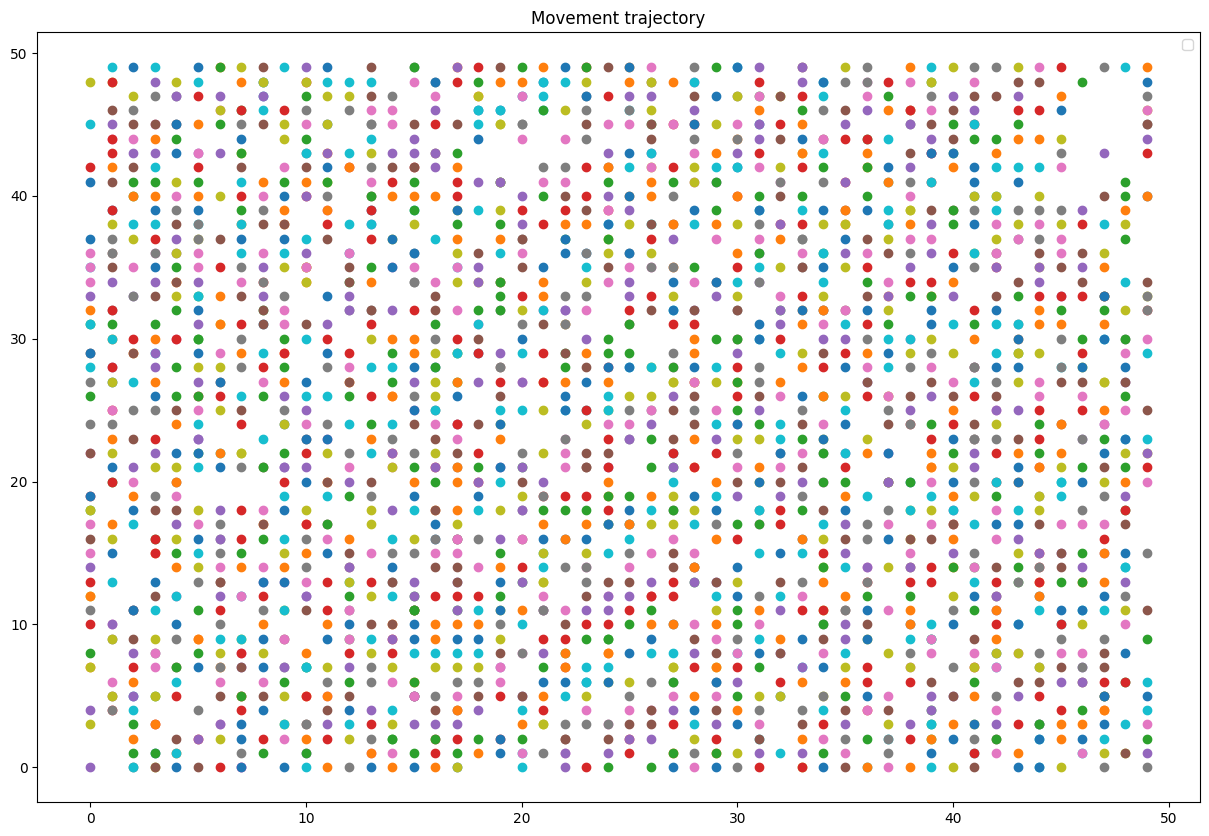

In [69]:
plt.figure(figsize=(15, 10))
plt.title("Movement trajectory")

n = 1

for n in range(len(observed_predators)):
    plt.scatter([val[0] for val in observed_predators[n].trajectory[:1]], [val[1] for val in observed_predators[n].trajectory[:1]])

for n in range(len(observed_preys)):
    plt.scatter([val[0] for val in observed_preys[n].trajectory[:1]], [val[1] for val in observed_preys[n].trajectory[:1]])

# plt.plot([val[0] for val in observed_predators[n].trajectory], [val[1] for val in observed_predators[n].trajectory], label="predator")
# plt.plot([val[0] for val in observed_preys[n].trajectory], [val[1] for val in observed_preys[n].trajectory], label="prey")
# for i in range(10):
#     plt.plot([val[0] for val in observed_ones[i].trajectory], [val[1] for val in observed_ones[i].trajectory])
# plt.plot([val[0] for val in observed_ones[1].trajectory], [val[1] for val in observed_ones[1].trajectory])
# plt.plot([val[0] for val in observed_ones[2].trajectory], [val[1] for val in observed_ones[2].trajectory])
# plt.plot([val[0] for val in observed_ones[3].trajectory], [val[1] for val in observed_ones[3].trajectory])
# plt.plot([val[0] for val in observed_ones[4].trajectory], [val[1] for val in observed_ones[4].trajectory])
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


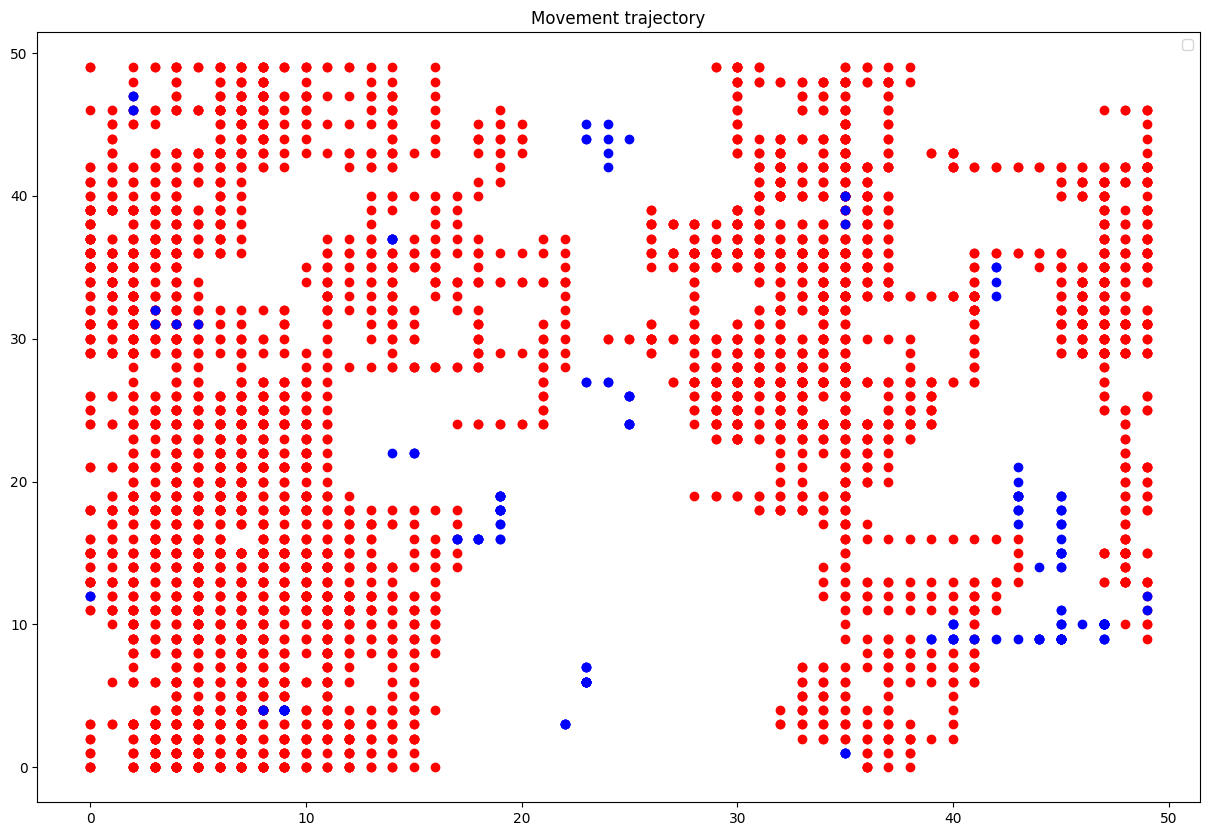

In [70]:
plt.figure(figsize=(15, 10))
plt.title("Movement trajectory")

n = 1

for n in range(20):
    op = random.choice(observed_predators)
    plt.scatter([val[0] for val in op.trajectory], [val[1] for val in op.trajectory], color="red")

for n in range(20):
    op = random.choice(observed_preys)
    plt.scatter([val[0] for val in op.trajectory], [val[1] for val in op.trajectory], color="blue")

# plt.plot([val[0] for val in observed_predators[n].trajectory], [val[1] for val in observed_predators[n].trajectory], label="predator")
# plt.plot([val[0] for val in observed_preys[n].trajectory], [val[1] for val in observed_preys[n].trajectory], label="prey")
# for i in range(10):
#     plt.plot([val[0] for val in observed_ones[i].trajectory], [val[1] for val in observed_ones[i].trajectory])
# plt.plot([val[0] for val in observed_ones[1].trajectory], [val[1] for val in observed_ones[1].trajectory])
# plt.plot([val[0] for val in observed_ones[2].trajectory], [val[1] for val in observed_ones[2].trajectory])
# plt.plot([val[0] for val in observed_ones[3].trajectory], [val[1] for val in observed_ones[3].trajectory])
# plt.plot([val[0] for val in observed_ones[4].trajectory], [val[1] for val in observed_ones[4].trajectory])
plt.legend()
plt.show()

In [71]:
with open("Trained RL/pred_q_table.pickle", "wb") as f:
    pickle.dump(predator_net.q_table, f)

FileNotFoundError: [Errno 2] No such file or directory: 'Trained RL/pred_q_table.pickle'

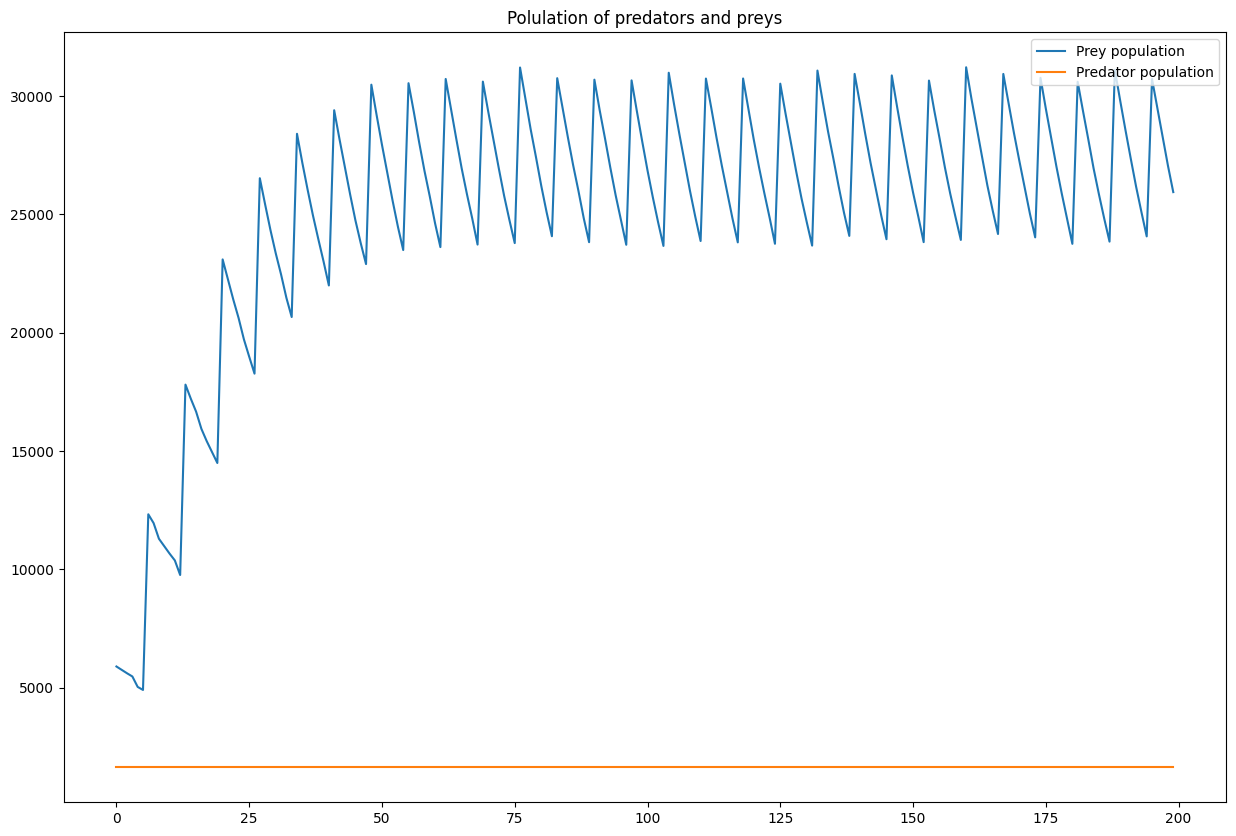

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("Polulation of predators and preys")
plt.plot(list(range(len(pred_c))), prey_c, label='Prey population')
plt.plot(list(range(len(pred_c))), pred_c, label='Predator population')
plt.legend(loc='upper right')
plt.show()

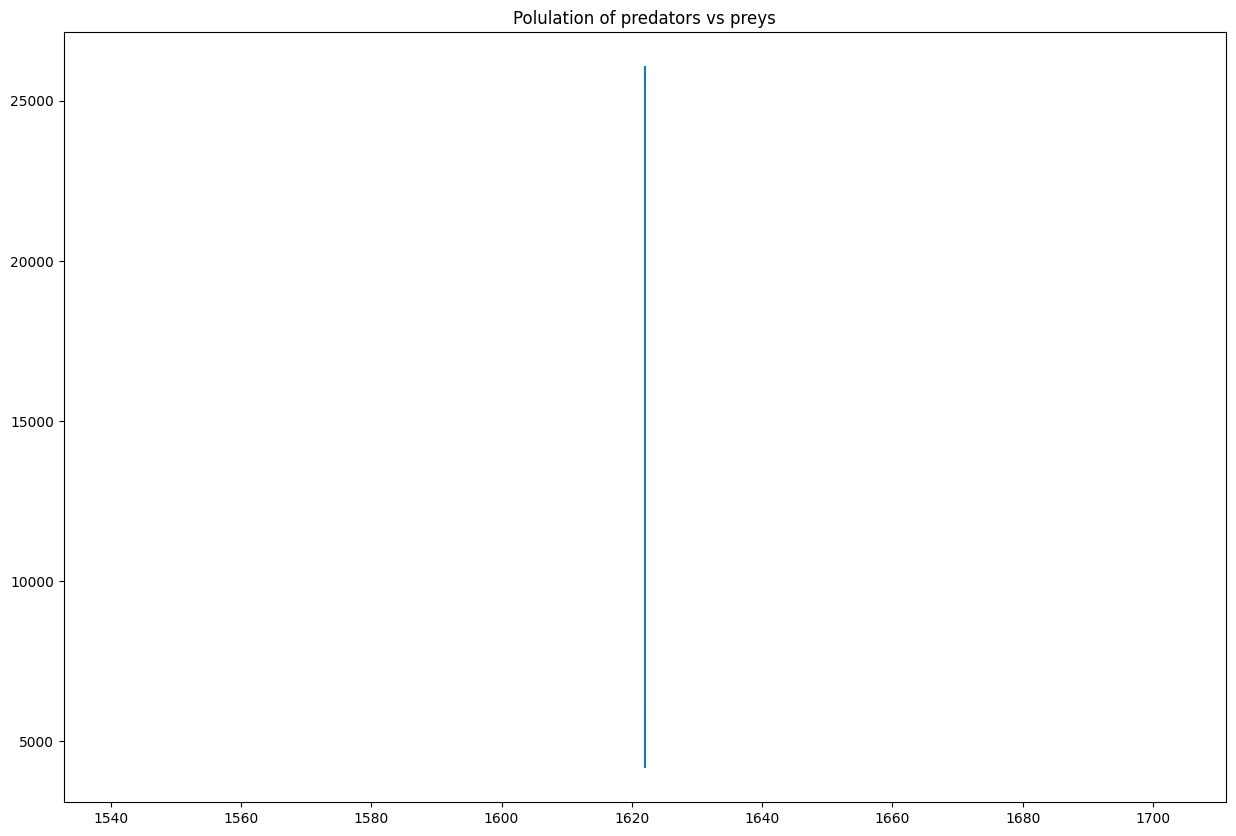

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("Polulation of predators vs preys")
plt.plot(pred_c, prey_c)
plt.show()

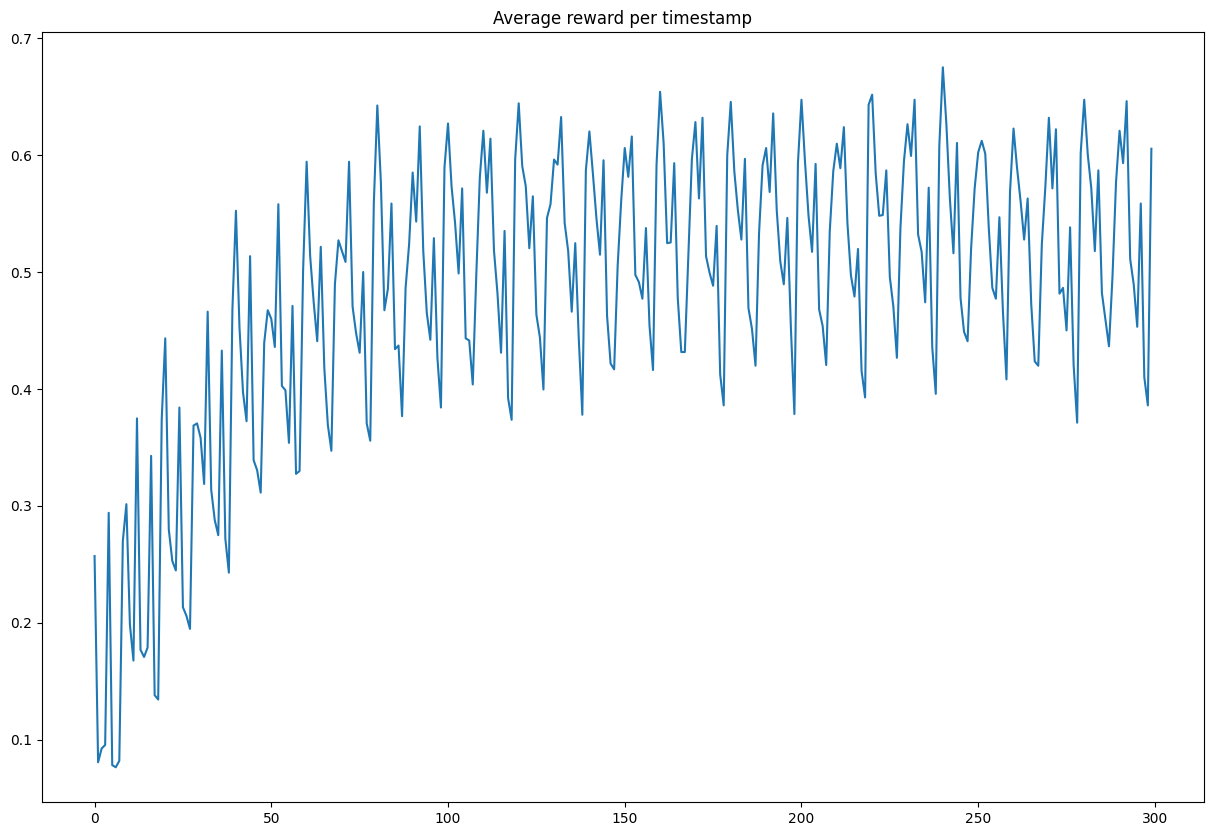

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("Average reward per timestamp")
plt.plot([val[1] for val in rewards])

In [ ]:
import json

list_history = [el.tolist() for el in history]
with open("history.json", "w") as f:
    json.dump(list_history, f)